# Exploring Environment Canada Weather Data with Python and Jupyter Notebooks

- By Siang Lim (siang@alumni.ubc.ca) - December 3rd 2017

This notebook demonstrates how to download Environment Canada's weather data using Python with popular data analysis libraries like pandas and Beautiful Soup. Read the accompanying blog post [here](https://www.ubcenvision.com/blog/2017/11/30/jupyter-part1.html) on the [UBC Envision](https://www.ubcenvision.com) website for more details.

To run this notebook on the cloud, use [Binder](https://mybinder.org/) or the [Syzygy](http://intro.syzygy.ca/getting-started/) platform. 

Feel free to use, copy, paste, modify or distribute this notebook however you wish.

*These examples are provided as-is with no guarantee that they will work in the future if Environment Canada modifies their API.*

## Updates:
- March 13th 2020:
    - Environment Canada API updated. `getHourlyData()` updated with skiprows=0.
    - Updated requirements.txt so this notebook works on Binder without messing with the libraries


- October 4th 2018: 
    - Environment Canada API updated, we need to skip 15 rows instead of 16. `getHourlyData()` updated with skiprows=15

# Part I: Data Extraction & Cleaning

In [17]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from dateutil import rrule
from datetime import datetime, timedelta
from bs4 import BeautifulSoup
import requests
import re

In [18]:
# We'll need `fuzzywuzzy` to look up weather stations later
# Run "!pip install fuzzywuzzy --user" if you get an error

# !pip install fuzzywuzzy --user
from fuzzywuzzy import fuzz

## How to download one month of data:

In [19]:
month = "01" # January
year = "2020" # 2020
stationID = 51442 #Vancouver

base_url = "http://climate.weather.gc.ca/climate_data/bulk_data_e.html?"
query_url = "format=csv&stationID={}&Year={}&Month={}&timeframe=1".format(stationID, year, month)
api_endpoint = base_url + query_url

print("Click me to download CSV data:")
print(api_endpoint)

Click me to download CSV data:
http://climate.weather.gc.ca/climate_data/bulk_data_e.html?format=csv&stationID=51442&Year=2020&Month=01&timeframe=1


## Function for calling the Environment Canada API

In [14]:
# Call Environment Canada API
# Returns a dataframe of data
def getHourlyData(stationID, year, month):
    base_url = "http://climate.weather.gc.ca/climate_data/bulk_data_e.html?"
    query_url = "format=csv&stationID={}&Year={}&Month={}&timeframe=1".format(stationID, year, month)
    api_endpoint = base_url + query_url
    return pd.read_csv(api_endpoint, skiprows=0)

## How to download data between a specified date range

In [20]:
stationID = 51442
start_date = datetime.strptime('Jun2015', '%b%Y')
end_date = datetime.strptime('Jun2016', '%b%Y')

frames = []
for dt in rrule.rrule(rrule.MONTHLY, dtstart=start_date, until=end_date):
    df = getHourlyData(stationID, dt.year, dt.month)
    frames.append(df)

weather_data = pd.concat(frames)
weather_data['Date/Time'] = pd.to_datetime(weather_data['Date/Time'])
weather_data['Temp (°C)'] = pd.to_numeric(weather_data['Temp (°C)'])

## Plot average data and a rolling average
Notice the broken lines, they indicate missing data points.

/Users/siang/anaconda/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


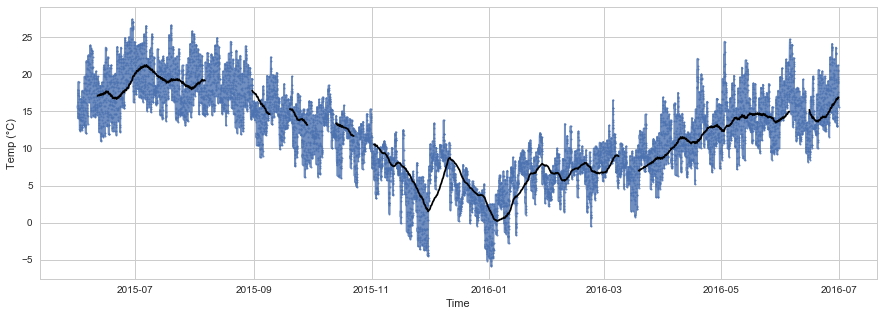

In [21]:
%matplotlib inline
sns.set_style('whitegrid')
fig = plt.figure(figsize=(15,5))
plt.plot(weather_data['Date/Time'], weather_data['Temp (°C)'], '-o', alpha=0.8, markersize=2)
plt.plot(weather_data['Date/Time'], weather_data['Temp (°C)'].rolling(window=250,center=False).mean(), '-k', alpha=1.0)
plt.ylabel('Temp (°C)')
plt.xlabel('Time')
plt.show()

## Fix missing data points by interpolation

In [22]:
# Don't really care about accuracy right now, use simple linear interpolation
weather_data['Temp (°C)'] = weather_data['Temp (°C)'].interpolate()

Then plot the data again:

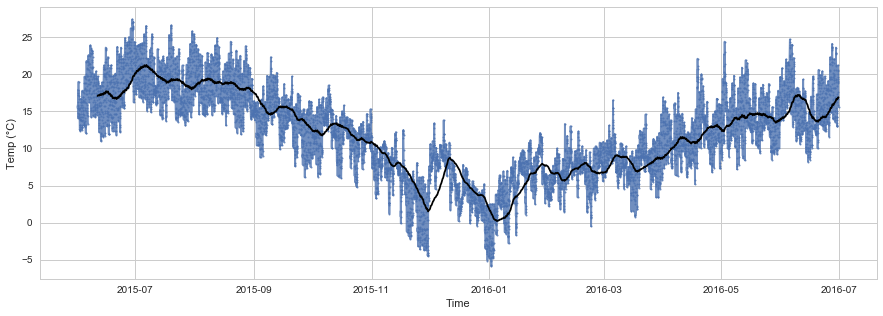

In [23]:
%matplotlib inline
sns.set_style('whitegrid')
fig = plt.figure(figsize=(15,5))
plt.plot(weather_data['Date/Time'], weather_data['Temp (°C)'], '-o', alpha=0.8, markersize=2)
plt.plot(weather_data['Date/Time'], weather_data['Temp (°C)'].rolling(window=250,center=False).mean(), '-k', alpha=1.0)
plt.ylabel('Temp (°C)')
plt.xlabel('Time')
plt.show()

## For convenience: Scrape StationIDs to lookup cities
This section demonstrates a simple Python script for scraping StationIDs from Environment Canada using Beautiful Soup.

The stationIDs are provided by province in this Environment Canada [page](http://climate.weather.gc.ca/historical_data/search_historic_data_e.html). Environment Canada limits the number of rows in the search results to 100 entries. This script loops through all pages and grabs the StationID, Station Name, Intervals and Year Range.


In [24]:
# Specify Parameters
province = "BC"      # Which province to parse?
start_year = "2006"  # I want the results to go back to at least 2006 or earlier
max_pages = 5        # Number of maximum pages to parse, EC's limit is 100 rows per page, there are about 500 stations in BC with data going back to 2006

# Store each page in a list and parse them later
soup_frames = []

for i in range(max_pages):
    startRow = 1 + i*100
    print('Downloading Page: ', i)
    
    base_url = "http://climate.weather.gc.ca/historical_data/search_historic_data_stations_e.html?"
    queryProvince = "searchType=stnProv&timeframe=1&lstProvince={}&optLimit=yearRange&".format(province)
    queryYear = "StartYear={}&EndYear=2017&Year=2017&Month=5&Day=29&selRowPerPage=100&txtCentralLatMin=0&txtCentralLatSec=0&txtCentralLongMin=0&txtCentralLongSec=0&".format(start_year)
    queryStartRow = "startRow={}".format(startRow)

    response = requests.get(base_url + queryProvince + queryYear + queryStartRow) # Using requests to read the HTML source
    soup = BeautifulSoup(response.text, 'html.parser') # Parse with Beautiful Soup
    soup_frames.append(soup)

## Parsing the Environment Canada page with Beautiful Soup

In [25]:
# Empty list to store the station data
station_data = []

for soup in soup_frames: # For each soup
    forms = soup.findAll("form", {"id" : re.compile('stnRequest*')}) # We find the forms with the stnRequest* ID using regex 
    for form in forms:
        try:
            # The stationID is a child of the form
            station = form.find("input", {"name" : "StationID"})['value']
            
            # The station name is a sibling of the input element named lstProvince
            name = form.find("input", {"name" : "lstProvince"}).find_next_siblings("div")[0].text
            
            # The intervals are listed as children in a 'select' tag named timeframe
            timeframes = form.find("select", {"name" : "timeframe"}).findChildren()
            intervals =[t.text for t in timeframes]
            
            # We can find the min and max year of this station using the first and last child
            years = form.find("select", {"name" : "Year"}).findChildren()            
            min_year = years[0].text
            max_year = years[-1].text
            
            # Store the data in an array
            data = [station, name, intervals, min_year, max_year]
            station_data.append(data)
        except:
            pass

# Create a pandas dataframe using the collected data and give it the appropriate column names
stations_df = pd.DataFrame(station_data, columns=['StationID', 'Name', 'Intervals', 'Year Start', 'Year End'])
stations_df.head()

,StationID,Name,Intervals,Year Start,Year End
0,1309,100 MILE HOUSE 6NE,"[Daily, Monthly]",1987,2020
1,559,108 MILE HOUSE ABEL LAKE,"[Daily, Monthly]",1987,2020
2,54238,ABBOTSFORD A,"[Hourly, Daily]",2016,2020
3,702,ABBOTSFORD A,"[Hourly, Daily, Monthly]",1953,2012
4,50308,ABBOTSFORD A,"[Hourly, Daily]",2011,2020


## Filtering Station Data
For example, to show only stations with hourly data, use the map() function.

In [26]:
# Show only data with hourly intervals
hourly_stations = stations_df.loc[stations_df['Intervals'].map(lambda x: 'Hourly' in x)]
hourly_stations.head()

,StationID,Name,Intervals,Year Start,Year End
2,54238,ABBOTSFORD A,"[Hourly, Daily]",2016,2020
3,702,ABBOTSFORD A,"[Hourly, Daily, Monthly]",1953,2012
4,50308,ABBOTSFORD A,"[Hourly, Daily]",2011,2020
5,374,ADDENBROKE ISLAND,"[Hourly, Daily, Monthly]",1994,2001
7,706,AGASSIZ RCS,"[Hourly, Daily, Monthly]",1994,2020


## Looking up stations
Now that we have the stationIDs, we can use Fuzzywuzzy and fuzzy string matching to lookup the station IDs with the city names. Here are 2 examples

In [27]:
# Find the stations that are in Whistler
string = "Whistler"
tolerance = 90

hourly_stations[hourly_stations['Name'].apply(lambda x: fuzz.token_set_ratio(x, string)) > tolerance]

,StationID,Name,Intervals,Year Start,Year End
467,348,WHISTLER,"[Hourly, Daily, Monthly]",1983,2014
468,43443,WHISTLER - NESTERS,"[Hourly, Daily, Monthly]",2005,2020
469,52178,WHISTLER A,[Hourly],2014,2020
470,43660,WHISTLER MOUNTAIN HIGH LEVEL,"[Hourly, Daily, Monthly]",2005,2010
471,44463,WHISTLER MOUNTAIN HIGH LEVEL REMOTE WIND,"[Hourly, Daily]",2005,2010
472,43680,WHISTLER MOUNTAIN LOW LEVEL,"[Hourly, Daily, Monthly]",2005,2010
473,46307,WHISTLER MOUNTAIN MID-STATION,"[Hourly, Daily]",2007,2010
474,47867,WHISTLER MOUNTAIN TIMING FLATS,"[Hourly, Daily]",2009,2010


In [28]:
# Find the stations that are in Vancouver
string = "Vancouver"
tolerance = 90

hourly_stations[hourly_stations['Name'].apply(lambda x: fuzz.token_set_ratio(x, string)) > tolerance]

,StationID,Name,Intervals,Year Start,Year End
434,888,VANCOUVER HARBOUR CS,"[Hourly, Daily, Monthly]",1976,2020
435,48328,VANCOUVER HILLCREST,"[Hourly, Daily]",2009,2010
436,889,VANCOUVER INT'L A,"[Hourly, Daily, Monthly]",1953,2013
438,51442,VANCOUVER INTL A,"[Hourly, Daily]",2013,2020
440,51357,VANCOUVER SEA ISLAND CCG,"[Hourly, Daily]",2013,2020
465,6833,WEST VANCOUVER AUT,"[Hourly, Daily, Monthly]",1994,2020


## Download Weather Data
Now that we know the station ID, we can use our getHourlyData() function to call the Environment Canada API with the station ID that we found. 

Here's how we get Whistler data from November 2016 to November 2017:

In [29]:
# Get Whistler weather data for November 2016 to November 2017
stationID = 43443
start_date = datetime.strptime('Nov2016', '%b%Y')
end_date = datetime.strptime('Nov2017', '%b%Y')

frames = []
for dt in rrule.rrule(rrule.MONTHLY, dtstart=start_date, until=end_date):
    df = getHourlyData(stationID, dt.year, dt.month)
    frames.append(df)

whistler = pd.concat(frames)
whistler['Date/Time'] = pd.to_datetime(whistler['Date/Time'])
whistler['Temp (°C)'] = pd.to_numeric(whistler['Temp (°C)'])
whistler.head()

,Longitude (x),Latitude (y),Station Name,Climate ID,Date/Time,Year,Month,Day,Time,Temp (°C),...,Wind Spd Flag,Visibility (km),Visibility Flag,Stn Press (kPa),Stn Press Flag,Hmdx,Hmdx Flag,Wind Chill,Wind Chill Flag,Weather
0,-122.95,50.13,WHISTLER - NESTERS,1100875,2016-11-01 00:00:00,2016,11,1,00:00,4.3,...,M,NaN,NaN,93.12,NaN,NaN,NaN,NaN,NaN,NaN
1,-122.95,50.13,WHISTLER - NESTERS,1100875,2016-11-01 01:00:00,2016,11,1,01:00,4.4,...,M,NaN,NaN,93.13,NaN,NaN,NaN,NaN,NaN,NaN
2,-122.95,50.13,WHISTLER - NESTERS,1100875,2016-11-01 02:00:00,2016,11,1,02:00,4.1,...,M,NaN,NaN,93.19,NaN,NaN,NaN,NaN,NaN,NaN
3,-122.95,50.13,WHISTLER - NESTERS,1100875,2016-11-01 03:00:00,2016,11,1,03:00,4.0,...,M,NaN,NaN,93.19,NaN,NaN,NaN,NaN,NaN,NaN
4,-122.95,50.13,WHISTLER - NESTERS,1100875,2016-11-01 04:00:00,2016,11,1,04:00,4.1,...,M,NaN,NaN,93.17,NaN,NaN,NaN,NaN,NaN,NaN


## Let's plot the data for Whistler

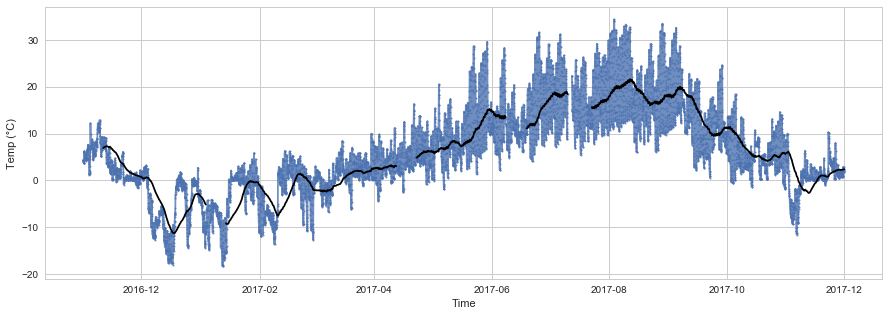

In [30]:
%matplotlib inline
sns.set_style('whitegrid')
fig = plt.figure(figsize=(15,5))
plt.plot(whistler['Date/Time'], whistler['Temp (°C)'], '-o', alpha=0.8, markersize=2)
plt.plot(whistler['Date/Time'], whistler['Temp (°C)'].rolling(window=250,center=False).mean(), '-k', alpha=1.0)
plt.ylabel('Temp (°C)')
plt.xlabel('Time')
plt.show()

## How to fix missing data points with interpolation

In [31]:
# Find the number of rows with a 'M' for missing temperature flag, or NaN for the actual temperature value
print('Missing data rows: ', whistler.loc[(~whistler['Temp Flag'].isnull()) | (whistler['Temp (°C)'].isnull())].shape[0])

# Do interpolation 
whistler['Temp (°C)'] = whistler['Temp (°C)'].interpolate()

# Did we fix everything?
print('Missing data rows: ', whistler.loc[(whistler['Temp (°C)'].isnull())].shape[0])

Missing data rows:  63
Missing data rows:  0


Re-plot the data

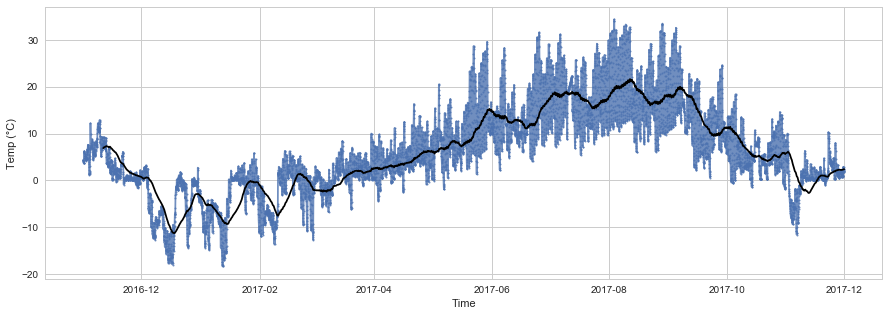

In [32]:
%matplotlib inline
sns.set_style('whitegrid')
fig = plt.figure(figsize=(15,5))
plt.plot(whistler['Date/Time'], whistler['Temp (°C)'], '-o', alpha=0.8, markersize=2)
plt.plot(whistler['Date/Time'], whistler['Temp (°C)'].rolling(window=250,center=False).mean(), '-k', alpha=1.0)
plt.ylabel('Temp (°C)')
plt.xlabel('Time')
plt.show()

# Exporting Data

We'll export the dataframes in CSV format so we don't have to re-download the data every time we restart Jupyter:

In [33]:
stations_df.to_csv('stations.csv')
whistler.to_csv('whistler.csv')